In [35]:
import numpy as np 
import math
import matplotlib.pyplot as plt
import scipy.integrate 
import pandas as pd
from numpy import random
from deap import creator, base, tools, algorithms 
from multiprocessing import Pool

### <font color = 'brown'>Visualizing Raw Data</font>

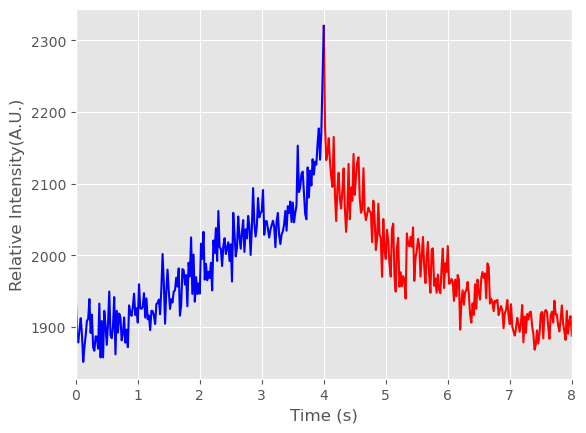

In [36]:
# DATA = pd.read_table("/Users/cmdb/Desktop/JOHNSON_rotation/dynamin_model/PythonCode/RAWDATA/expdataBB_from4.dat", header=None,sep=r"\s+",names=['time','expInt','expSEM'])
# #print(DATA[0:5])

# x = DATA['time']
# y = DATA['expInt']
# y_WHAT = DATA['expSEM']


# plt.plot(x, y, color = 'purple')

# plt.xlabel("Time (s)")
# plt.ylabel("Relative Intensity(A.U.)")
# plt.show()

# plt.plot(x, y_WHAT, color = 'pink')

# plt.xlabel("Time (s)")
# plt.ylabel("SEM")
# plt.show()

DATA_new = pd.read_table("/Users/cmdb/Desktop/JOHNSON_rotation/dynamin_model/PythonCode/RAWDATA/Dynamin1AB_kinetics_RawData.csv", header=None,sep=',',names=['time','expInt', 'expSEM'])
DATA_new_filtered = DATA_new[(DATA_new['time'] >= -4.00) & (DATA_new['time'] <= 0)]

#print(DATA_new_filtered[0:5])

DATA_4to4 = DATA_new[(DATA_new['time'] >= -4.00) & (DATA_new['time'] <= 4)]

x_new = DATA_4to4['time']+4
y_new = DATA_4to4['expInt']


#y_SEM= DATA_4to4['expSEM']

# plt.plot(x_new, y_SEM, color = 'orange')

# plt.xlabel("Time (s)")
# plt.ylabel("SEM")
# plt.show()

plt.style.use('ggplot') 
plt.plot(x_new[(x_new >= 4.0) & (x_new <= 8)], y_new[(x_new >= 4.0) & (x_new <= 8)], color='red')
plt.plot(x_new[(x_new >= 0) & (x_new < 4.02)], y_new[(x_new >= 0) & (x_new < 4.02)], color='blue')
plt.tick_params(right=False, top=False)

plt.xlabel("Time (s)")
plt.xlim(0,8)
plt.ylabel("Relative Intensity(A.U.)")
plt.savefig('dynamin_raw_fluorescence.png', dpi=900)
plt.show()



# <font color='red'>The class belows has the cost function and ODEs, as well as the plotting function</font>


In [335]:
'''
The deterministic model of biological oscillator
''' 
class Oscillator: 
	
	def __init__(self, parameter_ranges, params, Dsol0): #Dmem0): 
		#parameter_ranges and params will only include those PARAMETERS that will be UNDER OPTIMIZATION
		self.nParams = len(params)   
		self.paramsToOpt = params #model parameters to be optimized
		self.parameter_ranges = parameter_ranges #allowed parameter ranges  
		self.tMax = 8.5
		
		#3D to 2D lengthscale in um
		self.h = 0.01
		VAratio=1.91
		self.Atotal=4.34
		self.Acluster=0.023
		self.V=self.Atotal*VAratio
	#Dimensionality factor, should be the same in dense and dilute
		self.gamma = self.V/(self.Atotal*self.h)
	#define system geometry for the dense clusters.
		# self.AtotalDense=0.57
		# self.AclusterDense=0.026
		# self.VDense=self.AtotalDense*VAratio 

	# #Dimensionality factor, should be same in dense and dilute
	# 	self.gammaDense = self.VDense/(self.AtotalDense*self.h)
	# 	#print("VALUE OF slef.gammaDENSE IS: " + str(self.gamma))    
	# 	self.densIncrease = 7 #factor increase in density on the membrane
		targetIncrease=45 #how much should intensity increase 
		print("AB isoform is GOINGGGGGG!")              
		
		self.Dsol0 = Dsol0 #initial dynamin conc.
		#self.Dmem0 = Dmem0 #initial dynamin mem copies/um2

		expDt=0.02 
		nTimePoints=int(self.tMax/expDt)
		self.timePoints=[i*expDt for i in range(nTimePoints)] 
		self.expdata_unfiltered = pd.read_table("/Users/cmdb/Desktop/JOHNSON_rotation/dynamin_model/PythonCode/RAWDATA/Dynamin1AB_kinetics_RawData.csv", header=None,sep=',',names=['time','expInt', 'expSEM'])
		self.expdata_0 = self.expdata_unfiltered[(self.expdata_unfiltered['time'] >= -4.00) & (self.expdata_unfiltered['time'] <= 4)]
		new_index = range(len(self.expdata_0))
		self.expdata = self.expdata_0.set_index(pd.Index(new_index))
		startToZero = 4 
		self.expTime = self.expdata.time + startToZero 

        #make relative intensity higher!
		self.delIntensity=(np.max(self.expdata.expInt)-targetIncrease*self.expdata.expInt[0])/(1.0-targetIncrease)
		print('delIntensity HAS A VALUE OF: '+str(self.delIntensity))
        
		self.modes = [self.evaluate_parms]    
		self.threshold = -500000  

		
	def costChi(self, Y): 
		#Define relative intensity that is compared to the experimental data
		relInt=(self.expdata.expInt-self.delIntensity)/(self.expdata.expInt[0]-self.delIntensity)
		sem=self.expdata.expSEM/(self.expdata.expInt[0]-self.delIntensity)
		copies=Y*self.V*602
		# c=copies[3]/self.Atotal #Rdilute
		ac=copies[1]/self.Atotal #Ddilute
		acd=copies[4]/self.Acluster #Dclus2D
		ad=copies[5]/self.Acluster #Dclus3D
		#ae=copies[6]/self.Acluster #Dclus_hydro

        #relative intensity in cluster compared to dilute
		intensRatio=np.divide((acd+ad+ac), ac[0]) #relative intensity over time compared to initial amount of dynamin at the beginning (Dmem)
		nPt=len(relInt)
		nPsol=len(acd)
		if(nPsol<nPt):
			cost=self.threshold*2
			print(nPsol)
			print("too few points in solution") 
			print(nPsol)
			print("need: "+str(nPt)+ " points.")
		else:
			sum=0
			for i in range(nPt):
				df=relInt[i]-intensRatio[i]
				sum=sum+df*df/(sem[i]*sem[i]) 
			cost=-sum
		return [cost]
    
		
	def isViableFitness(self, fit):
        #the cost function is to be maximized, greater than some threshold
		return fit >= self.threshold
		
	def isViable(self, point): 
		fitness = self.evaluate_parms(point)  
		
		return self.isViableFitness(fitness[0]) #don't need zero index if 1D
		
	#evaluates a candidate  
	def evaluate_parms(self, candidate): 
		solutions = self.simulate(candidate) 
		# copies=solutions*self.V*602
		# acd=copies[4]/self.Acluster #Dclus2D
		# ad=copies[5]/self.Acluster #Dclus3D

		# twoDvs3D=np.divide(acd[1:], ad[1:]) #ignore the 1st point

		chiPre=self.costChi(solutions)
		return [chiPre] # twoDvs3D[0]]

        
#simulate a candidate pre-stimulation
	def simulate(self, candidate):
		
		# Values to convert to 3D units 
		#DmemDens=self.Dmem0 #units of /um2
		DmemDens = candidate[8]
		RdiluteDens = candidate[1]
		RclusDens=DmemDens/candidate[3]  #5 is targetDensRatio

		# Input species concentrations
        #convert all densities to uM units
		Dsol0=self.Dsol0 #units of uM: this is equilibrium pre-activation
		Dmem0=DmemDens*self.Atotal/self.V/602.0 
		Rclus0=RclusDens*self.Acluster/self.V/602.0
		Rdilute0=RdiluteDens*self.Atotal/self.V/602.0
		D2Dclus = 0
		Dclus = 0
		Dclus_hydro = 0
		Ddis = 0
		initValues=np.array([Dsol0, Dmem0, Rclus0, Rdilute0, D2Dclus, Dclus, Dclus_hydro, Ddis])

        # rate constants for model (s^-1)
		kfDRC=candidate[0] #binding to cluster activator, irreversible
		kfDRD=candidate[4] #binding to dilute recruiter is reversible
		kfDydy=kfDRC*candidate[2] #4 is targetRateRatio
		kbDRD=Dsol0*Rdilute0/Dmem0*kfDRD
		kfhyd=candidate[5] #hydrolysis reaction of dynamin 
		kfhyd_propagation = candidate[6]
		GTPconc = candidate[7]
		#kfdisSol = candidate[9]
		#kfdisMem = candidate[10]
		kfdis = candidate[9]
		
		#kfdisProp = candidate[10]

		
		rateParams=np.array([kfDRC, kfDRD, kbDRD, self.gamma, kfDydy, kfhyd, kfhyd_propagation, GTPconc, kfdis]) # kfdisSol, kfdisMem]) #, kfdisProp])
		
        #Solve the ODE from 0 to tMax (8.5 seconds)
		solution = scipy.integrate.solve_ivp(fun=self.dynaminODE, method='Radau', t_span=(0, self.tMax), y0=initValues, t_eval=self.timePoints, args=(rateParams,), rtol=1e-7, atol=1e-9)
		return solution.y


	def dynaminODE(self, t, y, rateParams): 
		# Rate constants
		kfDRC=rateParams[0] #rate binding to activator in cluster, irreversible
		kfDRD=rateParams[1] #rate binding to dilute recruiter from solution
		kbDRD=rateParams[2] #rate of UNbinding from membrane - seems to be used to unbind from dynamin Dmem0
		gamma=rateParams[3] #a demensionality factor taking into account the volume and area of the system
		kfDydy=rateParams[4] #rate constant for dynamin-to-dynamin assembly
		# new parameters for disassembly
		kfhyd=rateParams[5] #rate of hydrolysis of final dynamin helix
		kfhyd_propagation = rateParams[6]
		GTPconc=rateParams[7]
		#kfdisSol = rateParams[8]
		#kfdisMem = rateParams[9]
		kfdis = rateParams[8]
		#kfdisProp = rateParams[8]

		# Species ("initValues" called in simulate)
		Dsol0 = y[0]
		Dmem0 = y[1]
		Rclus0 = y[2] #Aclus in paper
		Rdilute0 = y[3] #Rmem in paper
		D2Dclus = y[4]
		Dclus = y[5]
		Dclus_hydro = y[6]
		Ddis = y[7]

		# 2nd order rate expressions 
		bind3DtoCluster = kfDRC*Dsol0*Rclus0 #rate of dynamin binding to the cluster from solution (3D)
		bind2DtoCluster = kfDRC*gamma*Dmem0*Rclus0 #rate of dynamin binding to the cluster from 2D
		bind3DtoDilute = kfDRD*Dsol0*Rdilute0 #rate of dynamin binding to recruiter (not in cluster) from solution (3D)
		bind2DtoDyn = kfDydy*gamma*Dmem0*D2Dclus #rate of dynamin on membrane binding to dynamin in cluster formed from 2D
		bind2Dto3DDyn = kfDydy*gamma*Dmem0*Dclus #rate of dynamin on membrane binding to dynamin cluster formed from 3D
		bind3DtoDyn = kfDydy*Dsol0*D2Dclus #rate of dynamin binding to 3D dynamin
		bind3Dto3DDyn = kfDydy*Dsol0*Dclus #rate of dynamin binding to 3D dynamin (cluster bound)

		# New, added expressions for rate of Dclus_hydro
		creation_Dclus_hydro = kfhyd*Dclus*GTPconc 
		creation_2Dclus_hydro = kfhyd*D2Dclus*GTPconc
		prop2Dclus = kfhyd_propagation * D2Dclus * Dclus_hydro
		propDclus = kfhyd_propagation * Dclus * Dclus_hydro
		
		#disDhydroSol = kfdisSol*Dclus_hydro
		#disDhydroMem = kfdisMem*Dclus_hydro
		disDhydrotoDis = kfdis*Dclus_hydro
		#disDhydroProp = kfdisProp*Ddis*Dclus_hydro


        #dynamin in solution - Dsol
		Dsol_ODE = -bind3DtoCluster - bind3DtoDilute + (kbDRD*Dmem0) - bind3DtoDyn - bind3Dto3DDyn #+ disDhydroSol
        #dynamin on membrane - Dmem
		Dmem_ODE = -bind2DtoCluster + bind3DtoDilute - (kbDRD*Dmem0) - bind2DtoDyn - bind2Dto3DDyn #+ disDhydroMem
        #available (unbound) recruiter on the cluster membrane - Aclus
		Aclus_ODE = -bind3DtoCluster - bind2DtoCluster
        #available (unbound) recruiter on the membrane dilute - Rmem
		Rmem_ODE = -bind3DtoDilute + (kbDRD*Dmem0)
        #Dynamin in cluster from 2D  - D2dclus
		D2dclus_ODE = bind2DtoCluster + bind2DtoDyn + bind2Dto3DDyn - creation_2Dclus_hydro - prop2Dclus
    	#Dynamin in cluster from 3D - Dclus
		Dclus_ODE = bind3DtoCluster + bind3DtoDyn + bind3Dto3DDyn - creation_Dclus_hydro - propDclus
		#Dynamin hdyrolyzed species after Dclus + D2Dclus GTP hydrolysis
		Dclus_hydro_ODE = creation_2Dclus_hydro + creation_Dclus_hydro + prop2Dclus + propDclus - disDhydrotoDis #- disDhydroSol - disDhydroMem #- disDhydroProp

		Ddis_ODE = disDhydrotoDis #+ disDhydroProp  

		dydt=np.array([Dsol_ODE, Dmem_ODE, Aclus_ODE, Rmem_ODE, D2dclus_ODE, Dclus_ODE, Dclus_hydro_ODE, Ddis_ODE])
		return(dydt)
    
	def plotModel(self, candidate, file = None, showConc = False, mode = None, save = None):     		
		t = self.timePoints

		expInt = np.copy(self.expdata.expInt)
		delIntensity = np.copy(self.delIntensity)
		time_model = np.copy(self.timePoints)
		time_exp = np.copy(self.expTime)

		relInt = (expInt-delIntensity)/(expInt[0]-delIntensity)

		concentrations = self.simulate(candidate)
		copies = concentrations*self.V*602
		
		ac=copies[1]/self.Atotal #Ddilute
		acd=copies[4]/self.Acluster #Dclus2D
		ad=copies[5]/self.Acluster #Dclus3D
		#ae=copies[6]/self.Acluster #DclusHydro

        #2D vs 3D recruitment growth
		twoDvs3D=np.divide(acd[1:], ad[1:]) #ignore the 1st point
       
        #relative intensity in cluster compared to dilute
		intensRatio=np.divide((acd+ad+ac), ac[0])
		#plt.style.use('ggplot') 
		plt.plot(time_exp, relInt, color="green",label="Experiment", alpha = 0.7)
		plt.plot(time_model, intensRatio, color="black", label='Model', linewidth = 3.5)

		plt.tick_params(right=False, top=False)
		plt.xlabel('Time (s)')
		plt.xlim(0,8)
		plt.ylabel('Relative Intensity (A.U.)')
		legend = plt.legend(loc = 'upper right', prop={'size': 12})
		legend.get_frame().set_facecolor('white')
		legend.get_frame().set_edgecolor('black')
		plt.show()

		# Concentrations for time series plot
		Dsol = concentrations[0]
		Dmem = concentrations[1]
		D2dclus = concentrations[4]
		Dclus = concentrations[5]
		Dclus_hydro = concentrations[6]
		Ddis = concentrations[7]

		TOTAL = Dsol + Dmem + D2dclus + Dclus_hydro + Dclus + Ddis


		D2dclus_CN = concentrations[4] *self.V*602
		Dclus_CN = concentrations[5]*self.V*602
		Dclus_hydro_CN = concentrations[6]*self.V*602
		#Ddis_CN = concentrations[7]*self.V*602
		
		if save == True:
			plt.style.use('ggplot') 
			#plt.gca().set_facecolor('white')
			plt.plot(time_exp, relInt, color="green",label="Experiment", alpha = 0.7)
			plt.plot(time_model, intensRatio, color="black", label='Model', linewidth = 3)

			plt.tick_params(right=False, top=False)
			# plt.gca().spines['top'].set_color('black')
			# plt.gca().spines['right'].set_color('black')
			# plt.gca().spines['bottom'].set_color('black')
			# plt.gca().spines['left'].set_color('black')
			plt.xlabel('Time (s)')
			plt.xlim(0,8)
			plt.ylabel('Relative Intensity (A.U.)')
			legend = plt.legend(loc = 'upper left', prop={'size': 12})
			legend.get_frame().set_facecolor('white')
			legend.get_frame().set_edgecolor('black')
			plt.savefig('dynaminOpt_bestSolution.png', dpi=900)
			plt.close()

			plt.style.use('ggplot') 
			plt.plot(t, Dclus_hydro, color = 'purple', label = 'Dclus (hydro)', linewidth = 3.5)
			plt.plot(t, Dclus, color = 'blue', label = "Dclus", linewidth = 3.5)
			plt.plot(t, D2dclus, color = 'orange', label = 'D2dclus', linewidth = 3.5)
			plt.plot(t, Ddis, color = "red", label = 'Ddis', linewidth = 3.5)
			plt.tick_params(right=False, top=False)
			plt.xlabel('Time (s)')
			plt.xlim(0,8)
			plt.ylabel('Concentration (uM)')
			
			legend = plt.legend(loc = 'upper left', prop={'size': 12})
			legend.get_frame().set_facecolor('white')
			legend.get_frame().set_edgecolor('black')
			plt.savefig('dynamin_Opt_speciesTrajectory.png', dpi=900)
			plt.close()
			
			plt.style.use('ggplot') 
			plt.plot(t, TOTAL, color = 'red', label = "Dclus + D2Dclus + Dsol + Dmem + Dclus_Hydro + Ddis")
			#plt.title("Conservation of Mass?")
			plt.ylabel("Total Concentration (uM)")
			plt.xlabel("Time(s)")
			plt.xlim(0,8)

			plt.tick_params(right=False, top=False)
			legend = plt.legend(loc = 'upper right', prop={'size': 12})
			legend.get_frame().set_facecolor('white')
			legend.get_frame().set_edgecolor('black')
			plt.savefig('dynaminOpt_consvOfMass.png', dpi=900)
			plt.close()	

			
			plt.style.use('ggplot') 
			
			#plt.plot(t, Dclus_hydro_CN, color = 'purple', label = 'Dclus (hydro)', linewidth = 3.5)
			plt.plot(t, Dclus_CN, color = 'blue', label = "Dclus", linewidth = 3.5)
			plt.plot(t, D2dclus_CN, color = 'orange', label = 'D2dclus', linewidth = 3.5)

			plt.tick_params(right=False, top=False)
			plt.xlabel('Time (s)')
			plt.xlim(0,8)
			plt.ylabel('Copy Number')
			
			legend = plt.legend(loc = 'upper left', prop={'size': 12})
			legend.get_frame().set_facecolor('white')
			legend.get_frame().set_edgecolor('black')
			plt.savefig('speciesCNtrajectory.png', dpi=900)
			plt.close()
		
		if showConc == True:
			plt.style.use('ggplot') 
			plt.plot(t, Dclus_hydro, color = 'purple', label = 'Dclus (hydro)', linewidth = 3.5)
			#plt.plot(t,Dclus_total, color = 'purple', label = "Dclus (total)", ls = '--', alpha = 0.3)
			plt.plot(t, Dclus, color = 'blue', label = "Dclus", linewidth = 3.5)
			plt.plot(t, D2dclus, color = 'orange', label = 'D2dclus', linewidth = 3.5)
			plt.plot(t, Ddis, color = "red", label = 'Ddis', linewidth = 3.5)

			# plt.plot(t, Dsol, color = 'red', label = 'Dsol')
			# plt.plot(t, Dmem, color = 'pink', label = 'Dmem')
			plt.tick_params(right=False, top=False)
			plt.xlabel('Time (s)')
			# plt.xlim(0,4)
			plt.ylabel('Concentration (uM)')
			
			legend = plt.legend(loc = 'upper left', prop={'size': 12})
			legend.get_frame().set_facecolor('white')
			legend.get_frame().set_edgecolor('black')			
			plt.show()


			plt.plot(t, Dclus_hydro, color = 'purple', label = 'Dclus (hydro)')
			plt.xlabel('Time (s)')
			plt.ylabel('Concentration (uM)')
			
			plt.legend(loc = 'upper right', prop={'size': 12})
			plt.show()

			plt.style.use('ggplot') 
			plt.plot(t, Dsol, color = 'green', label = 'Dsol', linewidth = 2)
			#plt.plot(t, Dmem, color = 'pink', label = 'Dmem', linewidth = 3)
			plt.tick_params(right=False, top=False)
			plt.xlabel('Time (s)')
			# plt.xlim(0,4)
			plt.ylabel('Concentration (uM)')
			
			legend = plt.legend(loc = 'upper right', prop={'size': 12})
			legend.get_frame().set_facecolor('white')
			legend.get_frame().set_edgecolor('black')			
			plt.show()


			plt.style.use('ggplot') 
			plt.plot(t, Dmem, color = 'pink', label = 'Dmem', linewidth = 2)
			#plt.plot(t, Dmem, color = 'pink', label = 'Dmem', linewidth = 3)
			plt.tick_params(right=False, top=False)
			plt.xlabel('Time (s)')
			# plt.xlim(0,4)
			plt.ylabel('Concentration (uM)')
			
			legend = plt.legend(loc = 'upper right', prop={'size': 12})
			legend.get_frame().set_facecolor('white')
			legend.get_frame().set_edgecolor('black')			
			plt.show()


			plt.style.use('ggplot') 
			plt.plot(t, TOTAL, color = 'red', label = "Dclus + D2Dclus + Dsol + Dmem + Dclus_Hydro")
			#plt.title("Conservation of Mass?")
			plt.ylabel("Total Concentration (uM)")
			plt.xlabel("Time(s)")
			plt.tick_params(right=False, top=False)
			legend = plt.legend(loc = 'upper right', prop={'size': 12})
			legend.get_frame().set_facecolor('white')
			legend.get_frame().set_edgecolor('black')			
			plt.show()	
			print(TOTAL[0])
			
			plt.style.use('ggplot') 
			
			#plt.plot(t, Dclus_hydro_CN, color = 'cyan', label = 'Dclus (hydro)')
			plt.plot(t, Dclus_CN, color = 'pink', label = "Dclus")
			plt.plot(t, D2dclus_CN, color = 'orange', label = 'D2dclus')
			#plt.plot(t, Ddis_CN, color = "red", label = 'Ddis')

			
			plt.tick_params(right=False, top=False)
			plt.xlabel('Time (s)')
			plt.ylabel('Copy Number')
			
			legend = plt.legend(loc = 'upper left', prop={'size': 12})
			legend.get_frame().set_facecolor('white')
			legend.get_frame().set_edgecolor('black')
			plt.show()
			

			# Dmem_uM = Dmem/self.Atotal*self.V*602 
			# plt.style.use('ggplot') 
			# plt.plot(t, Dmem_uM, color = 'green', label = 'Dmem')

			# plt.xlabel('Time (s)')
			# plt.ylabel('Concentration (/uM^2)')
			
			# plt.legend(loc = 'upper right', prop={'size': 12})
			# plt.show()

		if file is not None:
			f1 = open(str(file), "w")
			dfs = pd.DataFrame([self.timePoints, intensRatio, twoDvs3D]).T
			dfs.to_csv(f1, sep='\t', header=["time", "intensRatio", "twoDvs3d"])

![Alt text](image-5.png)

# <font color='red'>Solver runs the genetic algorithm (you'll see in __init__, uses package called DEAP for genetic operations)</font>

# <font color='grey'>
A parameter is a single rate constant or concentration of macromolecule (dynamin)
 - which is a gene!
A genotype is a combination of parameters 
 - a combination of genes - like a chromosome
A phenotype is a single number/solution
 - the chi-squared COST, fitness of the genotype (how well it matches the experimental data)
The population is the collections of all of the indivudals (genotypes -> phenotype) in a geneeration
 - reminder: evolution CANNOT occur on the individual level

How do the operators actually work
 - mutation
 - crossover (mate)
 - selection 

 Operators work on the population level
 
 The GA is most sensitive to population size
 </font>

In [241]:
'''
The main class
'''
class Solver:
	def __init__(self, model, populationSize=3000, NGEN = 3, nsamples = 1e3):                                                      
		self.model = model            
		self.populationSize = populationSize         
		self.NGEN = NGEN  
		self.nsamples = int(nsamples) 	
		self.indpb = 0.75     	
		
		#GA operators
		creator.create("FitnessMax", base.Fitness, weights=(1.0,)) 
		creator.create("Candidate", list, fitness=creator.FitnessMax)  		
		self.toolbox = base.Toolbox()	 
		self.toolbox.register("candidate", self.generateCandidate)  #function to create individuals
		self.toolbox.register("population", tools.initRepeat, list, self.toolbox.candidate)   #function to create a population
		self.toolbox.register("mate", tools.cxTwoPoint) #crossover
		self.toolbox.register("mutate", self.mutateCandidate, indpb=self.indpb, mult=0.5) #mutation
		self.toolbox.register("select", tools.selTournament, tournsize=int(self.populationSize/10)) #selection	
	
	#estimate initial values with GA
	def findNominalValues(self):    	 	
		nominalVals = []
		fitnessVals = []
		for evalMode in self.model.modes: 
			nominalValsMode = []
			fitnessValsMode = []
			self.toolbox.register("evaluate", evalMode)  #creates a function used to evaluate the fitness of individuals in the population
			#initialize new random population
			self.popu = self.toolbox.population(self.populationSize)  	 
			
			for gen in range(self.NGEN):  
				print("Current generation")
				print(gen)
				#generate offsprings with crossover and mutations
				offspring = algorithms.varAnd(self.popu, self.toolbox, cxpb=0.5, mutpb=0.75)  
				#evaluate individuals
				fits = self.toolbox.map(self.toolbox.evaluate, offspring) 
				for fit, ind in zip(fits, offspring):
					[cost]=self.model.evaluate_parms(ind)  #evalutates the cost (chisquared) of each individual      
					
					if cost[0]>=self.model.threshold and ind not in nominalValsMode:  #appends the individual to the list of "good"
						nominalValsMode.append(ind)
						fitnessValsMode.append(fit[0]) 
						#twoDValsMode.append(twoD)  
					ind.fitness.values = fit[0]     
				#tournament selection
				self.popu = self.toolbox.select(offspring, k=len(self.popu))  #selects individuals for the next generation

			print("Number of viable points: " + str(len(nominalValsMode))) #number of individuals meeting threshold criterion
			nominalVals.extend(nominalValsMode)  
			fitnessVals.extend(fitnessValsMode)

		return [nominalVals, fitnessVals]        
		
	#creates an array of random candidates  
	def generateCandidate(self): 
		candidate = []
		for ind in range(self.model.nParams):
			low=self.model.parameter_ranges[self.model.paramsToOpt[ind]]["min"]
			hi=self.model.parameter_ranges[self.model.paramsToOpt[ind]]["max"]
			value=random.uniform(math.log10(low),math.log10(hi))
			candidate.append(pow(10, value))
		return creator.Candidate(candidate) 	
		
	def checkOutAllBounds(self, candidate):
		for idx, val in enumerate(candidate):
			if self.checkOutOfBounds(candidate, idx): 
				return True  
		return False      
				
	def checkOutOfBounds(self, candidate, idx): 
		#if out of bounds return True 
		if candidate[idx] < self.model.parameter_ranges[self.model.paramsToOpt[idx]]["min"] or candidate[idx] > self.model.parameter_ranges[self.model.paramsToOpt[idx]]["max"]: 
			return True
		return False    		
	
	#returns a tuple of mutated candidate	
	def mutateCandidate(self, candidate, indpb, mult): 	
		for idx, val in enumerate(candidate):	
			rnd = random.uniform(0, 1)
			if rnd >= indpb:
				rnd2 = random.uniform(1 - mult, 1 + mult)   
				candidate[idx] = val*rnd2	
				if candidate[idx] < self.model.parameter_ranges[self.model.paramsToOpt[idx]]["min"]: 
					candidate[idx] = self.model.parameter_ranges[self.model.paramsToOpt[idx]]["min"]  
				if candidate[idx] > self.model.parameter_ranges[self.model.paramsToOpt[idx]]["max"]:  
					candidate[idx] = self.model.parameter_ranges[self.model.paramsToOpt[idx]]["max"]    					
		return candidate,     
	
	def getViablePoints(self, points):
		viable = list() 
		#fitVals = []        
		i = 0
		print(" getting Viable points")        
		for point in points:  
			i += 1
			if i % 1000 == 0:
				print(i)     
			
			#check if point is viable
			fitness = self.model.evaluate_parms(point) 
			if(fitness[0] >= self.model.threshold):
			#if self.model.isViable(point):
				augPoint=[]
				augPoint.append(fitness)
				for j in range(self.model.nParams):
					augPoint.append(point[j])
				viable.append(augPoint)   		
				#fitVals.append(fitness[0])
		print("shape of viable")
		print(np.shape(viable))
		return viable          
	
	def run(self, save = None):    
		#estimate the initial viable set 
		[viablePoints, viableFitness] = self.findNominalValues()

		fitValues=[]
		negFitValues=[]   

		for i in range(len(viableFitness)):
			fitValues.append(viableFitness[i][0])
			negFitValues.append(-viableFitness[i][0])
            
		idSort=np.argsort(negFitValues) 
		
		print("Best solution from initial sampling")
		print("Fitness: ", fitValues[idSort[0]])
		print("Best parameters: ", (viablePoints[idSort[0]]))
		self.model.plotModel(viablePoints[idSort[0]], save = True)
		print("WORST solution from initial sampling")
		self.model.plotModel(viablePoints[idSort[len(idSort)-1]])

		if save == True:
				fname="optimizedParms_dynamin1AB.txt"
				sortFit=sorted(fitValues, reverse=True) #descending order
				#print(sortFit[len(viableFitness)-1])
				sortPoint1=[]
				sortPoint2=[]
				sortPoint3=[]
				sortPoint4=[]
				sortPoint5 = [] #for new
				
				idSort=np.argsort(negFitValues) 
				#print(idSort)
				for i in range(len(idSort)):
					index=idSort[i]
					optParms=viablePoints[int(index)]
					#curr2D=twoDVals[int(index)]
		
					kfDRC=optParms[0]
					kfDRD=optParms[4] #binding to dilute and cluster recruiter are coupled
					kfDydy=kfDRC*optParms[2] #candidate[1]
					Dsol0=self.model.Dsol0 #units of uM
					
					#new 
					kfhyd = optParms[5]
					kfhyd_propagation = optParms[6]
					GTPconc = optParms[7]

					DmemDens=self.model.Dmem0
					RclusDens=DmemDens/optParms[3]  
					RdiluteDens = optParms[1]
					kfDense = optParms[5]
					#convert all densities to uM units
					Dmem0=DmemDens*self.model.Atotal/self.model.V/602.0 
					# Rclus0=RclusDens*self.model.Acluster/self.model.V/602.0 #Rclus0 is never called....
					Rdilute0=RdiluteDens*self.model.Atotal/self.model.V/602.0
					#rates for model
					#off rates, s-1
					kbDRD=Dsol0*Rdilute0/Dmem0*kfDRD
					kbDRC=kbDRD
					
					allParms1=np.array([kfDRC, RdiluteDens, Dsol0, DmemDens]) 
					allParms2=np.array([kfDRD, kfDydy, RclusDens, kfDense])  
					allParms3=np.array([kbDRC, kbDRD, self.model.gamma])
					allParms4=np.array([optParms[2], optParms[3]]) # curr2D])
					allParms5=np.array([kfhyd, kfhyd_propagation, GTPconc])

					sortPoint1.append(allParms1)
					sortPoint2.append(allParms2)
					sortPoint3.append(allParms3)
					sortPoint4.append(allParms4)
					sortPoint5.append(allParms5)
					
					
				df=pd.DataFrame([sortFit, sortPoint1, sortPoint2, sortPoint3, sortPoint4, sortPoint5]).T
				df.to_csv(fname, sep='\t',header=["Chi2","kfDRC, RdiluteDens, Dsol0, DmemDens","kfDRD, kfDydy, RclusDens, kfDense", "kbDRC, kbDRD, gamma","rateRatio, densRatio", "kfhyd, kfhyd_propagation, GTPconc"])
				print("wrote to file")
				

# <font color='red'>Define parameter ranges and initial conditions</font>

In [403]:
## DEFINE YOUR RANGES FOR THE GA 

parameter_ranges = { 
            #units of uM-1s-1
            "kfDRC": {"min": 0.01, "max": 0.1}, # 0.0001 to 1
            "RdiluteDens": {"min": 1, "max": 500},           				        
            "targetRateR": {"min": 0.01, "max": 100},
            "targetDensR": {"min": 0.01, "max": 100},
            "kfDRD": {"min": 0.01, "max": 1}, # 0.0001 to 1
            #rate to bind activator in the dense phase
            #"kfDense": {"min": 0.0001, "max": 1},
            "kfhyd": {"min": 0.001, "max": 1}, # 0.0001 to 0.01
            "kfhyd_propagation": {"min": 0.01, "max": 0.1}, # 0.01 to 100
            "GTPconc": {"min":300, "max": 1000},
            "Dmem0": {"min": 10, "max": 80},
            #"kfdisSol": {"min": 0.001, "max": 4}, #must be smaller than kfhyd....?
            #"kfdisMem": {"min": 0.001, "max": 4}
            "kfdis": {"min": 0.001, "max": 1},
            #"kfdisProp": {"min": 0.001, "max": 1} 
            }   	
 
paramsToOpt=np.array(["kfDRC", "RdiluteDens", "targetRateR", "targetDensR", "kfDRD", "kfhyd", "kfhyd_propagation", "GTPconc", "Dmem0", "kfdis"]) # "kfdisSol", "kfdisMem"]) # "kfdisProp"])


# For when hydrolyzation and disassembly are coupled
# parameter_ranges = { 
#             #units of uM-1s-1
#             "kfDRC": {"min": 0.0001, "max": 1},
#             "RdiluteDens": {"min": 1, "max": 500},           				        
#             "targetRateR": {"min": 0.01, "max": 100},
#             "targetDensR": {"min": 0.01, "max": 100},
#             "kfDRD": {"min": 0.0001, "max": 1},
#             #rate to bind activator in the dense phase
#             #"kfDense": {"min": 0.0001, "max": 1},
#             "kfhyd": {"min": 0.0001, "max": 0.001},
#             "kfhyd_propagation": {"min": 1, "max": 30},
#             "GTPconc": {"min":300, "max": 1000},
#             "Dmem0": {"min": 10, "max": 80},
#             }   	
 
# paramsToOpt=np.array(["kfDRC","RdiluteDens","targetRateR","targetDensR","kfDRD", "kfhyd", "kfhyd_propagation", "GTPconc", "Dmem0"])



# <font color='red'>Simulate a model given input parameters</font>

AB isoform is GOINGGGGGG!
delIntensity HAS A VALUE OF: 1933.0938181818185


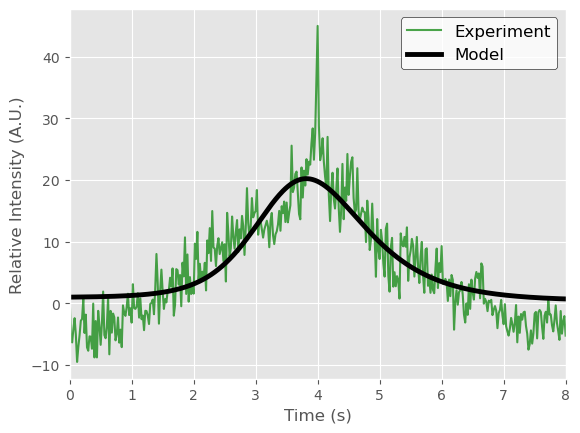

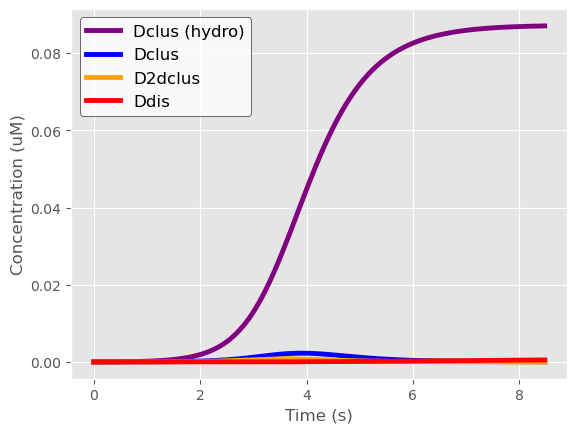

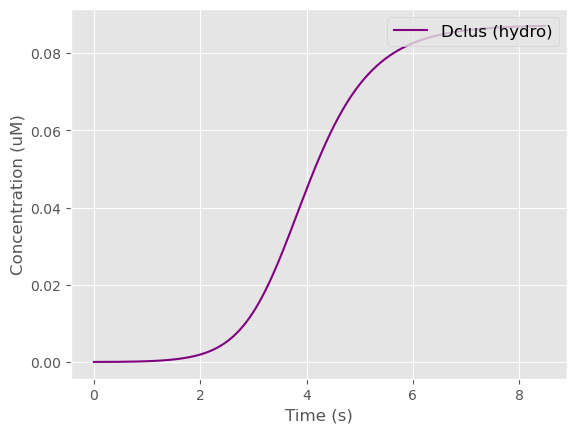

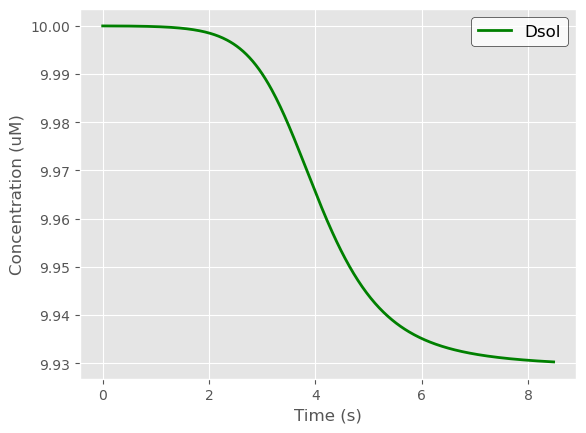

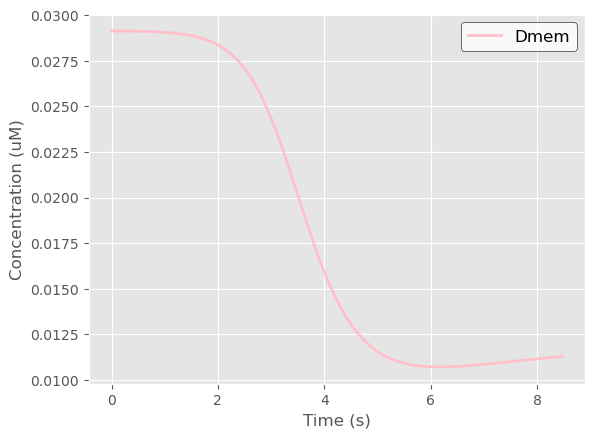

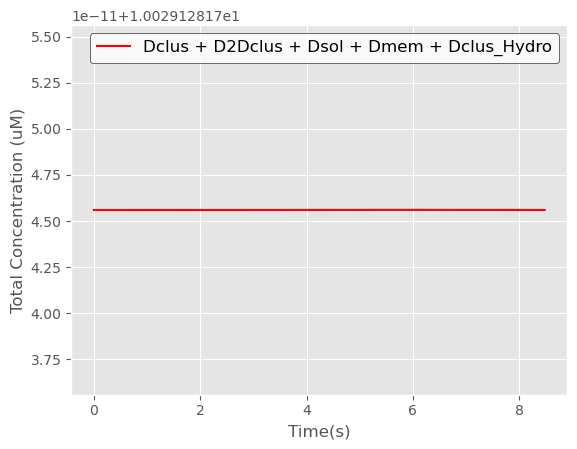

10.029128173745596


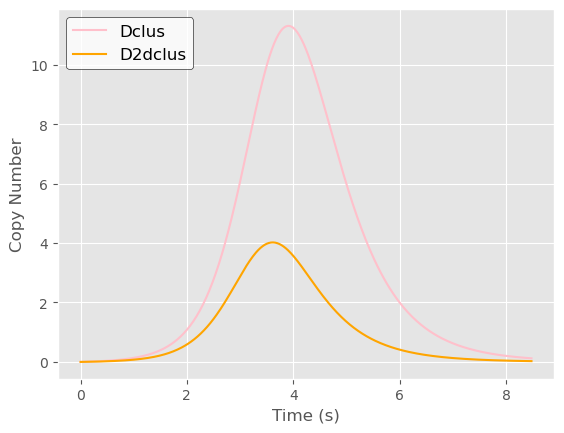

fitness: [-1063.9068624846054]


In [406]:
#initialize the model
model = Oscillator(parameter_ranges, paramsToOpt, 10) 
#Dsol0 = 10

#candidate_BAD = np.array([0.0024, 86.7117014087749, 53.76109799387347, 0.03613479551399369, 0.34973486053145464, 0.007797734909058662, 20, 644, 20.50569128216774])
#candidate_final = np.array([0.0017326069496228003, 86.7117014087749, 53.76109799387347, 0.03613479551399369, 0.34973486053145464, 0.007797734909058662, 30.207785720048385, 644.2414676371535, 20.50569128216774])
candidate_final = np.array([0.054862633123893466, 6.870239871997726, 6.910107234902721, 4.2773225646609685, 0.030357599889903022, 0.007087066437974544, 43.65504061454157, 664.3212981768131, 42.3884005894092])
candidate_final2 = np.array([0.020076182135188293, 24.686547953296408, 10.355894129212228, 1.3082750800496799, 0.9093710612099649, 0.008423431980843851, 24.765848342680332, 391.96162141534916, 80])


#most accurate species trajectory with kfdis and kfdis_prop
candidate_dis5 = np.array([0.015268039748554571, 18.929914002150742, 1.536418515305018, 0.049686738699049576, 0.4220449170869857, 0.2943462337274766, 2.6755418006052007, 475.5922143108078, 68.9547924241103, 0.0071658421916301444, 0.009240439826090862]) 
# with just kfdis
#Dclus_hydro contributing to fluorescence
candidate_dis8 = np.array([0.05905199403310263, 2.9491133723429157, 3.775805865079502, 0.24127437479708994, 0.08659788134051782, 0.003249889236085474, 0.0002789440392165226, 979.475393343128, 10, 0.4408237655722543])
candidate_dis_9 = np.array([0.026386950446547732, 70.48428962717071, 0.08118544176913692, 0.05427007213943198, 0.6842332376309281, 0.0008280459632642564, 0.00013122349104411572, 775.0227161697709, 12.694086293327155, 0.6075078713720932])
candidate_dis9 = np.array([0.3, 70.48428962717071, 0.08118544176913692, 0.05427007213943198, 0.6842332376309281, 0.01, 0.0001, 775.0227161697709, 12.694086293327155, 0.6075078713720932])

#Dclus_hydro NOT contributing to fluorescence
candidate_dis10 = np.array([0.03239656228082615, 6.889625563367709, 10.550307924179398, 2.7007391412671202, 0.2023328619812992, 0.008386938523196455, 0.07213078698635966, 727.13805173643, 78.12358037236638, 0.38791640018478646])
blah = np.array([0.023855564124655938, 23.342755435287415, 12.74371144052579, 1.3413501922115778, 0.010130324510081938, 0.01, 0.013824835787247454, 547.1310300003734, 80, 0.0022623621604249103])
blah2 = np.array([0.03339521491558783, 1, 9.39793269851037, 0.4713452690900984, 0.1244194178732287, 0.0072554761594620515, 0.01950888460163302, 706.0999389783, 60.314869396908534, 0.48356977251526284])
blah3 = np.array([0.06561537729440706, 7.27191153135228, 7.456383415657705, 5.907820398424979, 0.3541058897799419, 0.008913820380738104, 0.022617271272939842, 858.2539742695121, 56.862132890244915, 0.09997494855914253])
blah4 = np.array([0.04659476352450003, 1.6058275695110007, 15.232476685086569, 10.779187488257412, 0.011700914764712364, 0.01, 0.014425439364993105, 1000, 42.89761915286272, 0.022899055756944495])
blah5 = np.array([0.010317287912605718, 1.2336348025241994, 21.002494929569462, 0.09568557596617458, 0.0708628834666231, 0.009728258956040075, 0.0230439163503699, 434.3572012589499, 80, 0.034711542720481534])
blah6 = np.array([0.01, 28.304184082131947, 31.91931127935694, 0.4912933096664789, 0.6387814652271385, 0.009985833354753046, 0.01148473802568525, 601.6965536183433, 80, 0.06371691480437204])
blah7= np.array([0.019361999205621514, 1.7273350721170946, 21.041956437778996, 1.2794450092564251, 0.01, 0.01, 0.039265546848484024, 654.2917433319169, 61.51123229097505, 0.0025683079773102576])
blah8 = np.array([0.0674705768177257, 3.5450333501637723, 5.659474169166881, 3.1525445774695586, 0.026746623560939126, 0.008102404691699316, 0.034760816493483185, 772.9627552991186, 64.84236124492004, 0.13127831316834399])
blah9 = np.array([0.021469241965722294, 1.4786955820175538, 18.059175088171905, 2.31590164858789, 0.28409729802539363, 0.01, 0.04196794920361128, 643.3828667213467, 68.08693182012982, 0.47050683142120203])
# with kfhyd high!
blah10 = np.array([0.061630557897458076, 9.554682617811217, 14.673761731777532, 8.730706018948034, 0.030332844899852225, 0.032181925280677044, 0.02878427342411131, 372.8251859382504, 33.492156736161355, 0.0013320900914738248])


# With kfDisMem and kfDisSol
candidate_dis15 = np.array([0.031125291248195016, 5.665743613735634, 0.34347141598353953, 0.07131743305199469, 0.014149415688032883, 0.000940617513160253, 0.0004285640906754287, 717.5787528498314, 15.348430090979056, 0.47422103729266996, 0.024225246925108863])
candidate_dis16 = np.array([0.021999475852937708, 494.6695139106378, 1.1535014727960076, 0.09098922301252915, 0.6863109910033212, 0.001, 0.0009, 1000, 64.37251687355379, 0.5918253207854505, 0.01323448736678083])
candidate_dis17 = np.array([0.03935367161302807, 500, 0.01, 0.1084318337635615, 0.014826171555181178, 0.0001, 1.0967483836687627e-05, 1000, 30.251459825356513, 0.16466654947577014, 0.8624047823688513])
candidate_dis18 = np.array([0.03935367161302807, 500, 0.01, 0.1084318337635615, 0.014826171555181178, 0.001, 0.00009, 1000, 30.251459825356513, 0.16466654947577014, 0.8624047823688513])

# With just kfDisSol
candidate_disSol1 = np.array([0.04622496202645265, 15.95453482262027, 0.01, 0.10708620149704894, 0.01596975319160544, 0.0001, 0.001440003685100629, 1000, 13.965831077161015, 0.9198588969624103])
candidate_disSol2 = np.array([0.03643364080662373, 19.05123449911862, 4.114467490044273, 0.14281108143501367, 0.0683267088184179, 0.004096299819781437, 0.005283392037707891, 649.839651577421, 22.676067949723873, 0.5731014718840878])
candidate_disSol3 = np.array([0.0336295987688017, 27.15924668337768, 1.2001473705484622, 0.09497935525812057, 0.4536001270151421, 0.001, 0.0007014664913992817, 1000, 21.915571560977337, 0.6567453517940952])

# With kfDisMem and kfDisSol but DclusHdyro NOT contributing to fluorescence!
candidate__new = np.array([0.02044343880932403, 301.37185815291804, 0.0298594135386856, 0.04637585118278198, 0.35281905955785925, 0.0005079203776487649, 1.4764455292122713e-05, 665.853885622659, 33.731853251509236, 2, 0.2533920713021411])
candidate_new = np.array([0.018551681590610734, 81.60121018102282, 0.04409058290608488, 0.04537321259213306, 0.25043079575046095, 0.0011316614627373406, 0.00026643209104534573, 309.9226744345679, 44.32361733141505, 0.0881834200776992, 0.03161896422409056])


# kfDRC = candidate[0] 
# RdiluteDens = candidate[1] 
# kfDydy = kfDRC*candidate[2] 
# RclusDens = DmemDens/candidate[3]  
# kfDRD = candidate[4] 
# kfhyd = candidate[5] 
# kfhyd_propagate = candidate[6]
# GTPconc = candidate[7]
# Dmemo = candidate[8]
# kfdis = candidate[9]
# kfdisProp = candidate[10]

solutions = model.simulate(blah10) 
model.plotModel(blah10, showConc = True, mode = "test") #save = True)
timePts=model.timePoints
[fitness] = model.evaluate_parms(blah10) 
print("fitness: "+ str(fitness))

# <font color='red'>Use the GA to find the highest-fitness genotype (sets of parameters) over multiple generations</font>

AB isoform is GOINGGGGGG!
delIntensity HAS A VALUE OF: 1933.0938181818185
Current generation
0


/Users/cmdb/mambaforge/envs/ODE_solver_JOHNSON/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/Users/cmdb/mambaforge/envs/ODE_solver_JOHNSON/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Candidate' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


Current generation
1
Current generation
2
Current generation
3
Number of viable points: 23343
Best solution from initial sampling
Fitness:  -1063.9068624846054
Best parameters:  [0.061630557897458076, 9.554682617811217, 14.673761731777532, 8.730706018948034, 0.030332844899852225, 0.032181925280677044, 0.02878427342411131, 372.8251859382504, 33.492156736161355, 0.0013320900914738248]


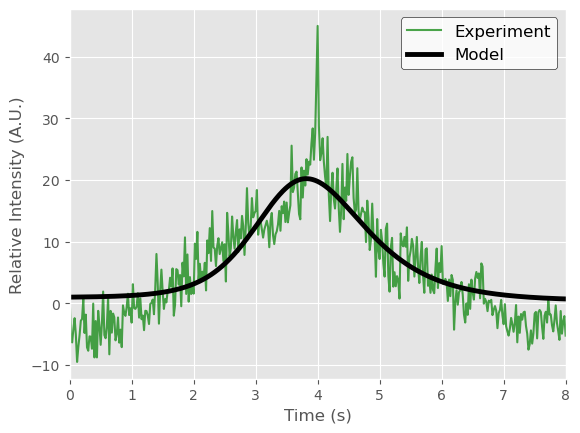

WORST solution from initial sampling


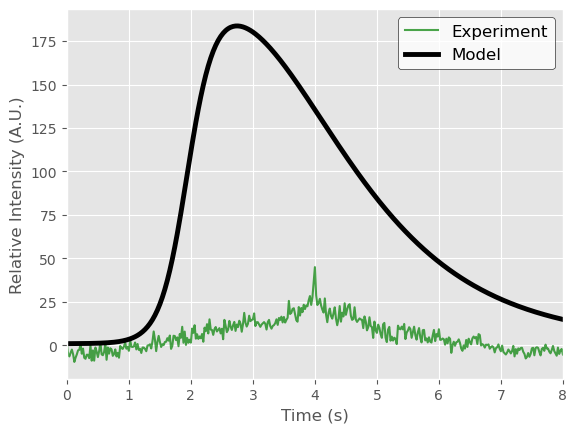

In [404]:
popSize = 8000
nGen = 4
nSamples = 2000
Dsol0=10

model = Oscillator(parameter_ranges, paramsToOpt, Dsol0)
solver = Solver(model, popSize, nGen, nSamples)
solver.run()


In [ ]:
# Use python multiprocessing "pool" to run multiple instances of the GA in parallel
def worker(solver):
    solver.run()

if __name__ == '__main__':
    popSize = 8000
    nGen = 4
    nSamples = 2000
    Dsol0=10

    model = Oscillator(parameter_ranges, paramsToOpt, Dsol0)

    # Create a list of solvers
    solvers = [Solver(model, popSize, nGen, nSamples) for _ in range(num_solvers)]

    # Create a pool of worker processes
    with Pool(processes=num_processes) as pool:
        pool.map(worker, solvers)


figure saved!


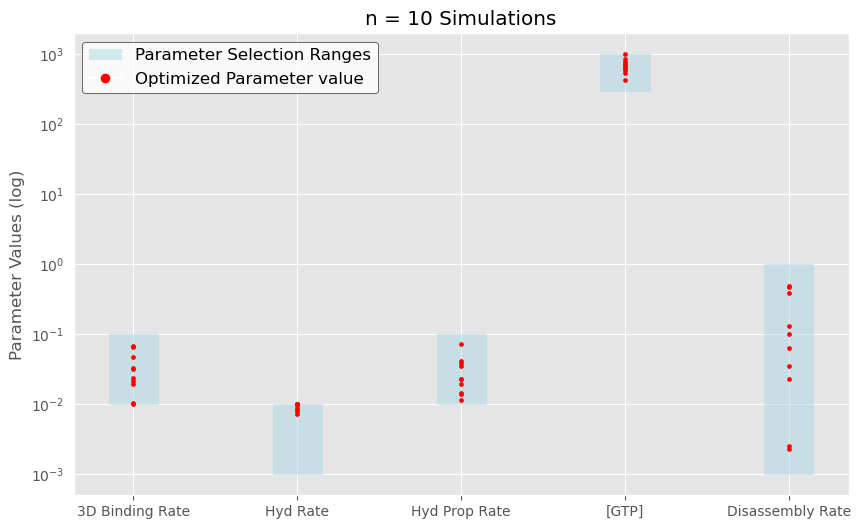

In [402]:

def plotParameterSolutions(parameterRanges, opt_param_values, color_simulation = False, save = False):
        parameters = list(parameterRanges.keys())
        
        plt.figure(figsize=(10, 6))

        handles = []  
        labels = []   

        for i, param in enumerate(parameters):
            min_val = parameterRanges[param]["min"]
            max_val = parameterRanges[param]["max"]
            plt.fill_between([i - 0.15, i + 0.15], min_val, max_val, color='lightblue', alpha=0.5, zorder=1)

        # Add handle and label for blue boxes only once
        handles.append(plt.Rectangle((0,0),1,1,fc="lightblue", alpha=0.5))
        labels.append("Parameter Selection Ranges")

        if color_simulation == True:
            colors = plt.cm.plasma 
            spread_factor = 0.2

            for j in range(len(opt_param_values[parameters[0]])):  
                color = colors(j / len(opt_param_values[parameters[0]]))  
                for i, param in enumerate(parameters):
                    val = opt_param_values[param][j]
                    x = i + spread_factor * (np.random.rand() - 0.5)  
                    plt.scatter(x, val, color=color, s=15, zorder=2)

        else:
            for i, param in enumerate(parameters):
                for val in opt_param_values[param]:
                    plt.scatter(i, val, color='red', s=8, zorder=2)

        # Add handle and label for red dots
        handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8))
        labels.append("Optimized Parameter value")

        plt.xticks(range(len(parameters)), parameters)
        plt.ylabel('Parameter Values (log)')
        plt.yscale('log')

        plt.tick_params(axis='y', which='both', left=False, right=False)
        legend = plt.legend(handles, labels, loc='upper left', prop={'size': 12})
        legend.get_frame().set_facecolor('white')
        legend.get_frame().set_edgecolor('black')
        plt.title("n = 10 Simulations")

        if save == True:
            plt.savefig('parameterRangesAndOpt.png', dpi=900)
            print("figure saved!")
        plt.show()
        

parameterRanges = { 
    #"Dmem": {"min": 10, "max": 80},
    "3D Binding Rate": {"min": 0.01, "max": 0.1}, 
    "Hyd Rate": {"min": 0.001, "max": 0.01}, 
    "Hyd Prop Rate": {"min": 0.01, "max": 0.1}, 
    "[GTP]": {"min":300, "max": 1000},
    "Disassembly Rate": {"min": 0.001, "max": 1},
}  

opt_param_values = {
    #"Dmem": [78.12358037236638, 80, 60.314869396908534, 56.862132890244915, 42.89761915286272, 80, 80, 61.51123229097505],
    "3D Binding Rate": [0.03239656228082615, 0.023855564124655938, 0.03339521491558783, 0.06561537729440706, 0.04659476352450003, 0.010317287912605718, 0.01, 0.019361999205621514, 0.0674705768177257, 0.021469241965722294], 
    "Hyd Rate": [0.008386938523196455, 0.01, 0.0072554761594620515, 0.008913820380738104, 0.01, 0.009728258956040075, 0.009985833354753046, 0.01, 0.008102404691699316, 0.01],
    "Hyd Prop Rate": [0.07213078698635966, 0.013824835787247454, 0.01950888460163302, 0.022617271272939842, 0.014425439364993105, 0.0230439163503699, 0.01148473802568525, 0.039265546848484024, 0.034760816493483185, 0.04196794920361128],
    "[GTP]": [727.13805173643, 547.1310300003734, 706.0999389783, 858.2539742695121, 1000, 434.3572012589499, 601.6965536183433, 654.2917433319169, 772.9627552991186, 643.3828667213467],
    "Disassembly Rate": [0.38791640018478646, 0.0022623621604249103, 0.48356977251526284, 0.09997494855914253, 0.022899055756944495, 0.034711542720481534, 0.06371691480437204, 0.0025683079773102576, 0.13127831316834399,  0.47050683142120203]
}



plot_final = plotParameterSolutions(parameterRanges, opt_param_values, save = True) #color_simulation = True)
